<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/Thesis_ch3_one_layer_temporal_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
rm -r dnn_osci     # delete old version in drive

rm: cannot remove 'dnn_osci': No such file or directory


In [2]:
!git clone https://github.com/katduecker/dnn_osci
%cd dnn_osci
%cd aet_pytorch/

Cloning into 'dnn_osci'...
remote: Enumerating objects: 537, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 537 (delta 68), reused 27 (delta 15), pack-reused 413
Receiving objects: 100% (537/537), 54.40 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (286/286), done.
/content/dnn_osci
/content/dnn_osci/aet_pytorch


In [3]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

import aet_dyn
import aet_net
# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def euler_dyn(model,input_,params_,t_,alpha_params,DEVICE,inp_on):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S,h_start,R_start = params_


    # alpha frequency & amplitude
    _af,_aa,_aph = alpha_params

    with torch.no_grad():

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dhdt = (torch.ones((model.dims[1],len(t_)+1))*h_start).to(DEVICE)
        dRdt = (torch.ones((model.dims[1],len(t_)+1))*R_start).to(DEVICE)
        dOdt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh = _aa*np.sin(2*np.pi*_af*t_+_aph)+_aa

        # preactivation (dot product of input and first weight matrix)
        Z,_,_ = model.forw_conv(input_)

        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        # adjust initial adaptation term (threshold)
        dRdt *= torch.max(Z)

        # scale for adaptation
        #r_scale = R*torch.max(Z).detach()


        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,_,_ = model.forw_conv(input_*boxcar[_it])

          # pre-activation
            dZdt[:,_it+1] = (Z + dhdt[:,_it] - dRdt[:,_it] - alpha_inh[_it])/(S/Z)

            # dynamics hidden layer
            dhdt[:,_it+1] = dhdt[:,_it] + dt/tau_h * (-dhdt[:,_it] + model.acti1(dZdt[:,_it+1],model.sig_param))

            # adaptation term
            dRdt[:,_it+1] = dRdt[:,_it] + dt/tau_R * (-dRdt[:,_it] + c*dhdt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc1(dhdt[:,_it+1]))

    return dZdt, dhdt, dRdt, dOdt


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


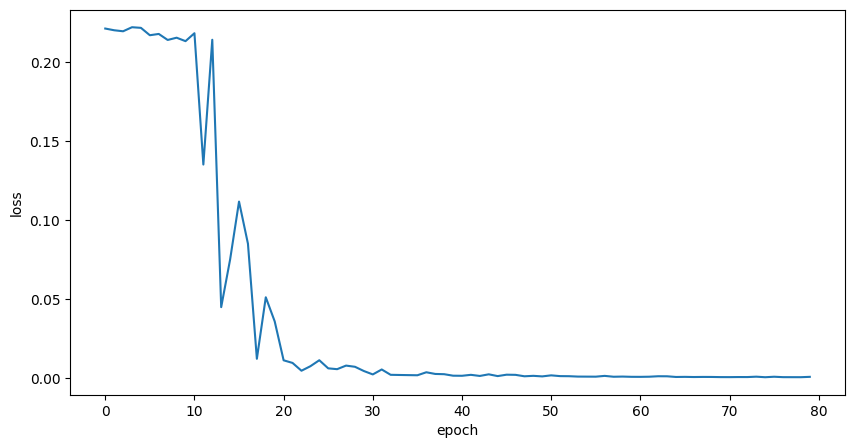

In [25]:
nn_dim_ = [28,68,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 0.1           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 80

beta_ = 0
p_ = 0
kl_reg_ = [0,0.01]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param = [2, -2.5, False] # sigmoid slope and shift in x direction

ortho_lmbda = 0 # orthogonality penalty

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda

# initialize model and weights
model = aet_net.net(params,lossfun)
model = aet_net.init_params(model,weight_init='uni')
optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

model.to(DEVICE)
loss_hist = model.train(optimizer,noise=False,print_loss=False)


plt.rcParams["figure.figsize"] = (10,5)
plt.plot(np.arange(model.num_ep),loss_hist.cpu().detach().numpy())
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [6]:
# create stimuli
x_train, y_train = aet_net.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

In [26]:
Z, H, O = model.forw_conv(x_train)
max(Z[2])

tensor(4.6458, grad_fn=<UnbindBackward0>)

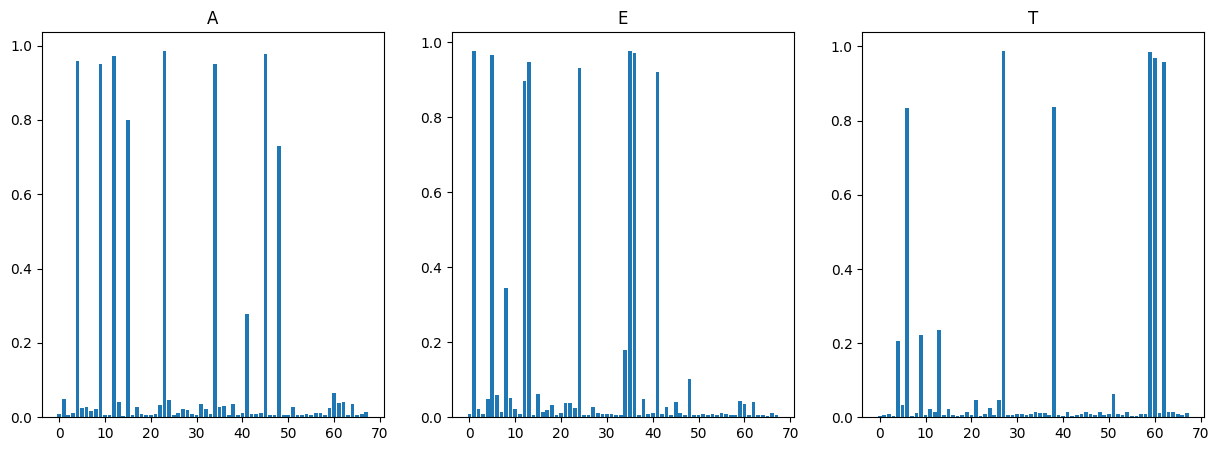

In [27]:
idx = np.array((0,5,10))#,-1))
label = ['A','E','T']


plt.rcParams["figure.figsize"] = (15,5)

fig, axs = plt.subplots(1,3)
axs = axs.ravel()

for i,ax in enumerate(axs):

    ax.bar(np.arange(nn_dim_[1]),H[idx[i]].detach().numpy().squeeze())
    ax.set_title(label[i])


In [30]:
# dynamics

tau_h = 0.01
tau_r = 0.1
c = 10
S = .4
h_start = 0
R_start = 0
dyn_params = [tau_h,tau_r,c,S,h_start,R_start]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

# dynamics alpha
aamp = 0
afreq = 10
aph = 0
alpha_params = [afreq,aamp,aph]
_io = 0

timevec = np.linspace(0,0.6,600)

Zt,Ht, Rt, Ot  = euler_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()


Z, H, O = model.forw_conv(x_train[0])
Z = Z.detach().cpu().numpy()
H = H.detach().cpu().numpy()
O = O.detach().cpu().numpy()

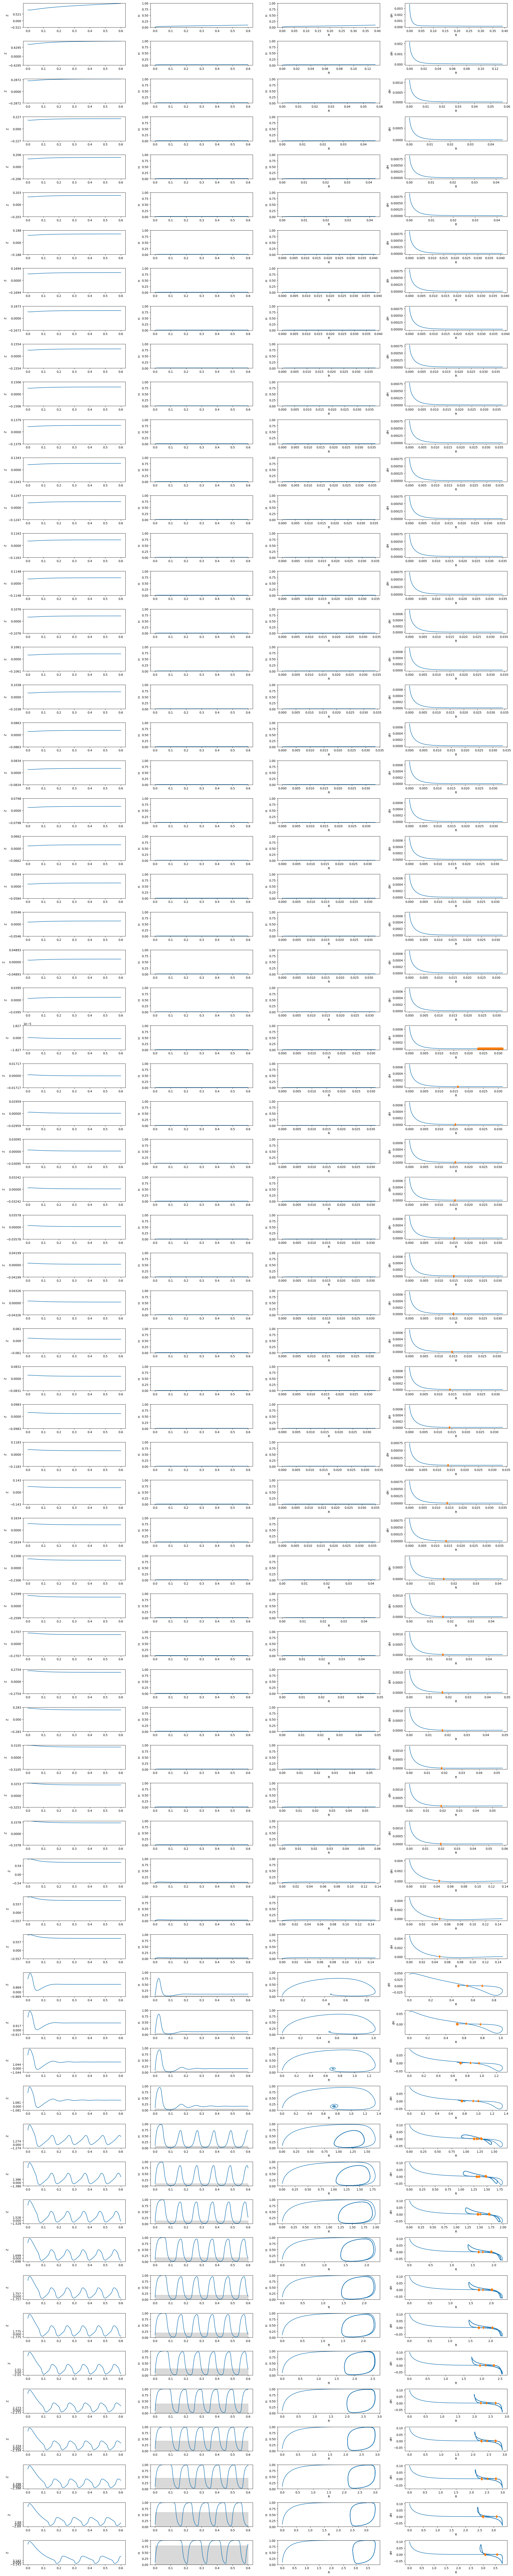

In [15]:

plt.rcParams["figure.figsize"] = (24,120)

fig, axs = plt.subplots(Zt.shape[0],4)

t = 0

for i,z in enumerate(np.argsort(Z)):
  axs[i,0].plot(timevec[t:],Zt[z,t+1:])
  axs[i,0].set_yticks((-Z[z],0,Z[z]))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(timevec[t:],Ht[z,t+1:])

  if aamp:
    axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H[z],timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')

  axs[i,1].set_ylim(0,1)
  axs[i,2].plot(Rt[z,t+1:],Ht[z,t+1:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(Ht[z])

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(Rt[z,t+1:],dH)
  axs[i,3].plot(Rt[z,(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')


fig.tight_layout()


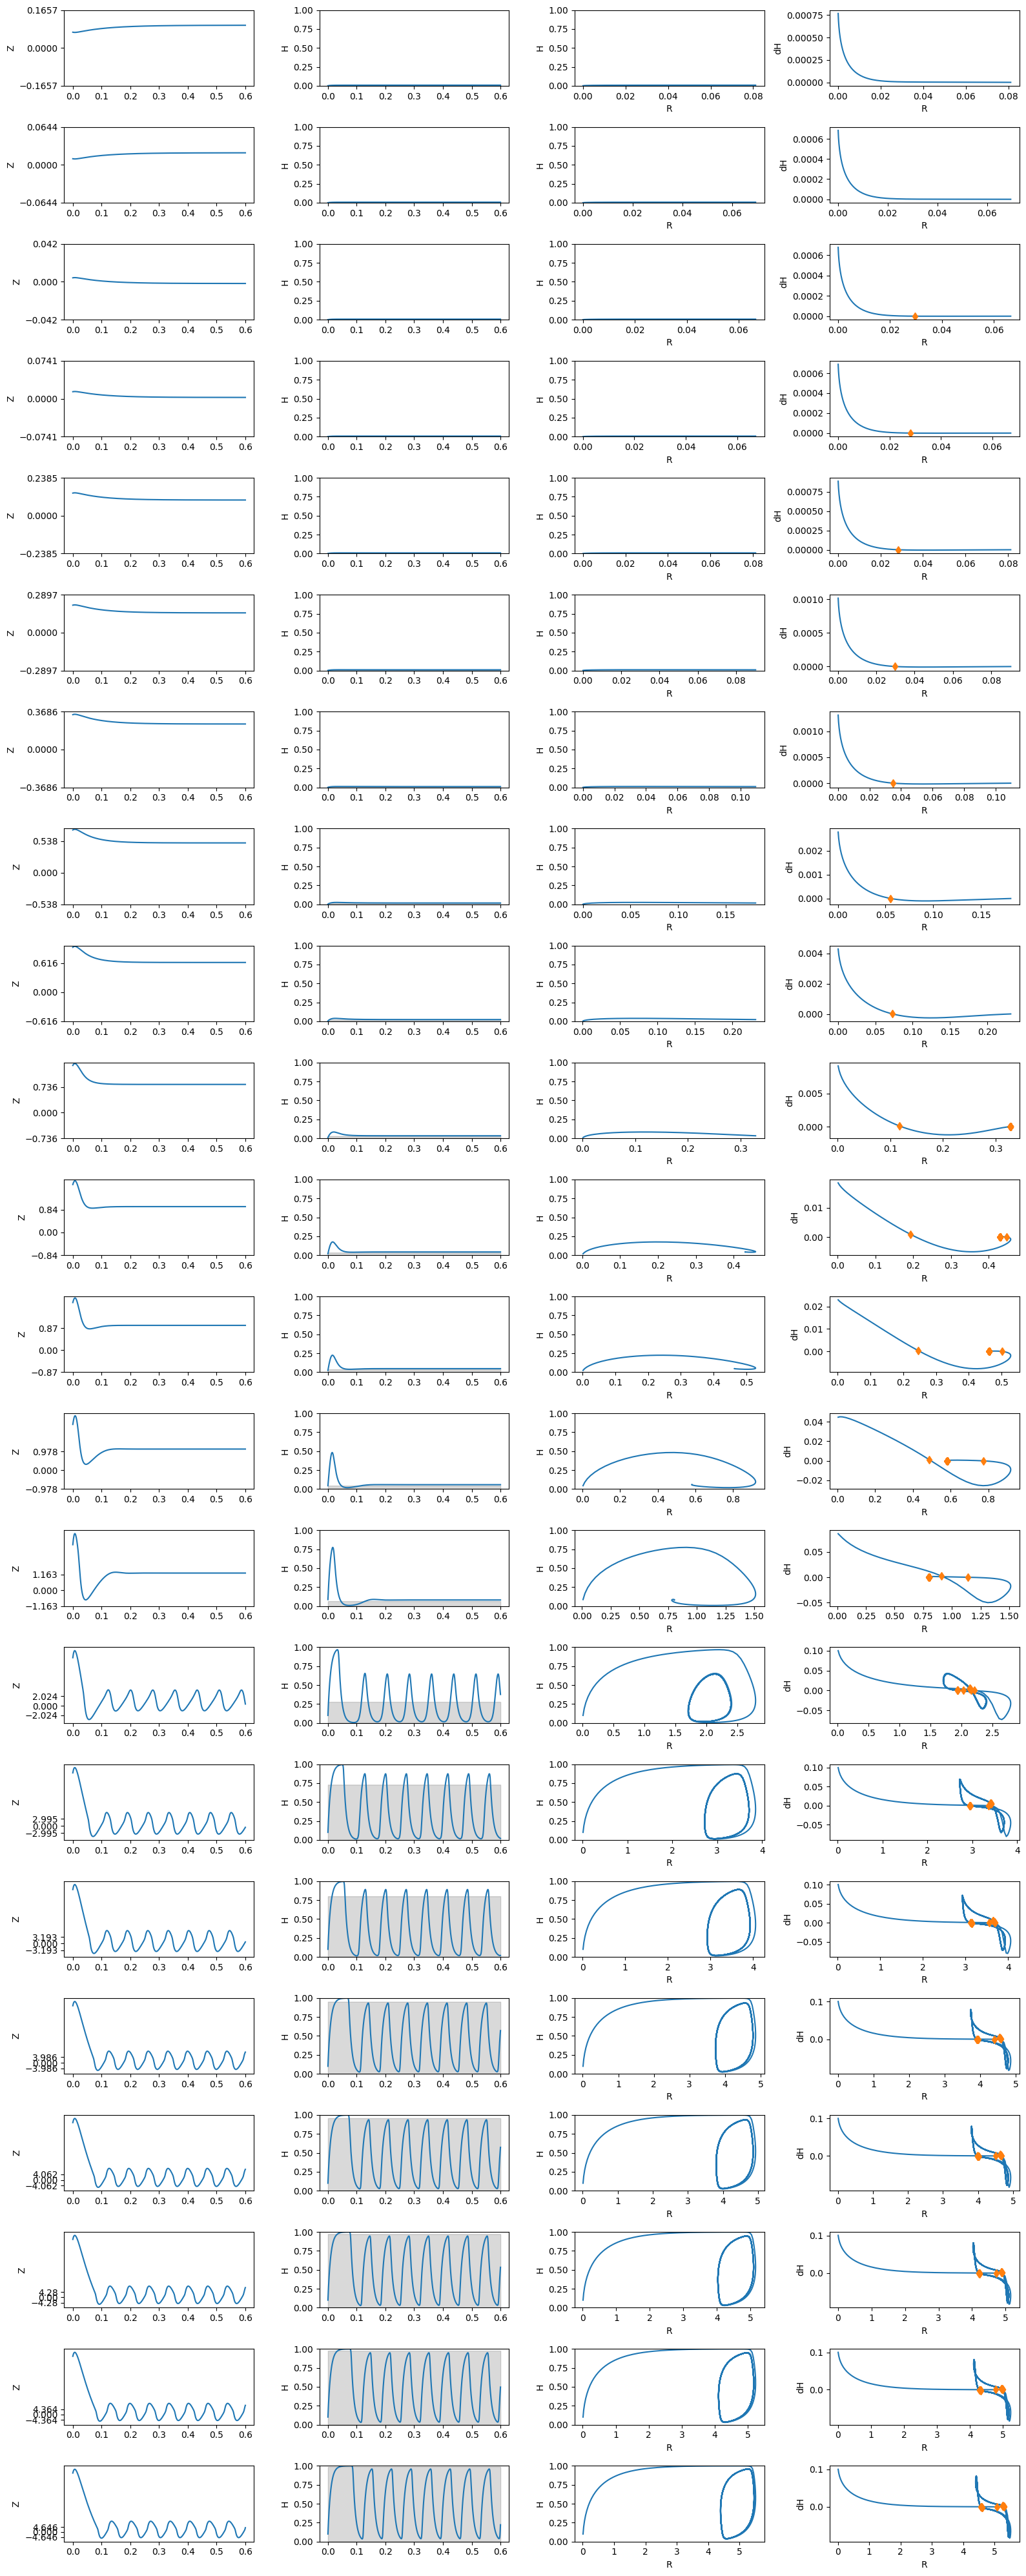

In [31]:
# better image - only show unique Z's
Z_round = np.round(Z,decimals=1)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

plt.rcParams["figure.figsize"] = (16,40)

fig, axs = plt.subplots(Z_round_unique_idx[1].shape[0],4)

t = 0

for i,z in enumerate(Z_round_unique_idx[1]):
  axs[i,0].plot(timevec[t:],Zt[Z_round_idx[z],t+1:])
  axs[i,0].set_yticks((-Z[Z_round_idx[z]],0,Z[Z_round_idx[z]]))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(timevec[t:],Ht[Z_round_idx[z],t+1:])

  if aamp:
    axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H[Z_round_idx[z]],timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')

  axs[i,1].set_ylim(0,1)
  axs[i,2].plot(Rt[Z_round_idx[z],t+1:],Ht[Z_round_idx[z],t+1:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(Ht[Z_round_idx[z]])

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(Rt[Z_round_idx[z],t+1:],dH)
  axs[i,3].plot(Rt[Z_round_idx[z],(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')


fig.tight_layout()


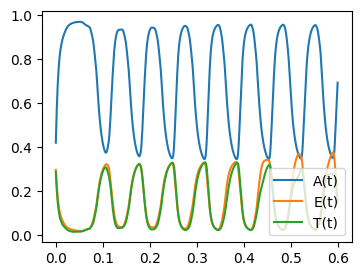

In [32]:
plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
plt.legend(('A(t)','E(t)','T(t)'),loc='lower right')

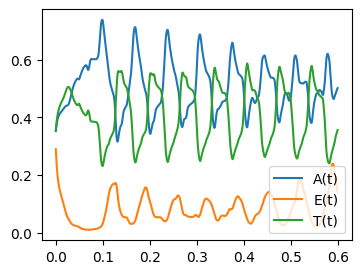

In [33]:
# check temporal codeness

inpt = x_train[0]*1.1 + x_train[-1]*0.9
Zt,Ht, Rt, Ot  = euler_dyn(model,inpt, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
plt.legend(('A(t)','E(t)','T(t)'),loc='lower right')


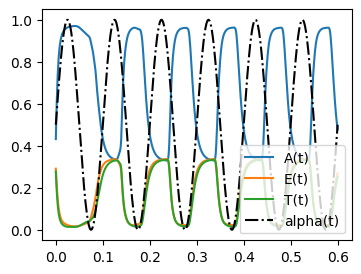

In [37]:
aamp = .5
afreq = 10
aph = 0
alpha_params = [afreq,aamp,aph]

Zt,Ht, Rt, Ot  = euler_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)


plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
if aamp:
    plt.plot(timevec[t:],aamp*np.sin(2*np.pi*afreq*timevec[t:]+aph)+aamp,color = 'k',linestyle='-.')

plt.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower right')


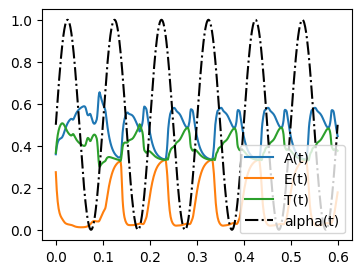

In [41]:
aamp = 0.5
afreq = 10
aph = 0
alpha_params = [afreq,aamp,aph]

inpt = x_train[0]*1.1 + x_train[-1]*0.9
Zt,Ht, Rt, Ot  = euler_dyn(model,inpt, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
if aamp:
    plt.plot(timevec[t:],aamp*np.sin(2*np.pi*afreq*timevec[t:]+aph)+aamp,color = 'k',linestyle='-.')

plt.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower right')

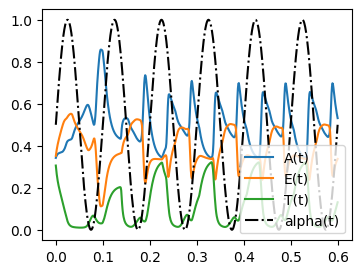

In [42]:
inpt = x_train[0]*1.1 + x_train[6]*0.9
Zt,Ht, Rt, Ot  = euler_dyn(model,inpt, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
if aamp:
    plt.plot(timevec[t:],aamp*np.sin(2*np.pi*afreq*timevec[t:]+aph)+aamp,color = 'k',linestyle='-.')

plt.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower right')

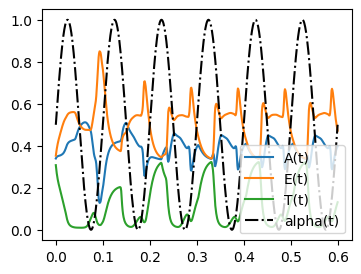

In [43]:

aamp = 0.5
afreq = 10
aph = 0
alpha_params = [afreq,aamp,aph]

inpt = x_train[5]*1.1 + x_train[0]*0.9
Zt,Ht, Rt, Ot  = euler_dyn(model,inpt, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
if aamp:
    plt.plot(timevec[t:],aamp*np.sin(2*np.pi*afreq*timevec[t:]+aph)+aamp,color = 'k',linestyle='-.')

plt.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower right')

In [ ]:

aamp = 0.5
afreq = 10
aph = 0
alpha_params = [afreq,aamp,aph]

inpt = x_train[-1]*1.1 + x_train[0]*0.9
Zt,Ht, Rt, Ot  = euler_dyn(model,inpt, dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

Zt = Zt.detach().cpu().numpy()
Ht = Ht.detach().cpu().numpy()
Rt = Rt.detach().cpu().numpy()
Ot = Ot.detach().cpu().numpy()

plt.rcParams["figure.figsize"] = (4,3)

plt.plot(timevec,Ot[:,1:].T)
if aamp:
    plt.plot(timevec[t:],aamp*np.sin(2*np.pi*afreq*timevec[t:]+aph)+aamp,color = 'k',linestyle='-.')

plt.legend(('A(t)','E(t)','T(t)','alpha(t)'),loc='lower right')